# Predicting Uber Fare Prices
## Mark Bowen & John Ruscito & Peyton Theil

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import pipeline
from sklearn.metrics import mean_squared_error
import seaborn as sns
from geopy import distance

### Import data and Inspect the Data

In [2]:
uber_data = pd.read_csv("uber.csv")
print("Shape of the Data: ", uber_data.shape)
uber_data.head()

Shape of the Data:  (200000, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
print(uber_data.isnull().sum())
uber_data = uber_data.dropna()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


## Data

### Feature Engineer pickup_datetime

In [4]:
uber_data.pickup_datetime = pd.to_datetime(uber_data.pickup_datetime, format = '%Y-%m-%d %H:%M:%S UTC', errors='coerce')

In [5]:
uber_data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
(uber_data.pickup_datetime == "NaT").sum()

0

Extract extra information from pickup_datetime. <br>
Year is not important since it will never repeat (i.e. it will never be 2019 again)

In [7]:
uber_data['pickup_month'] = uber_data.pickup_datetime.dt.month
uber_data['pickup_week'] = uber_data.pickup_datetime.dt.isocalendar().week
uber_data['pickup_day'] = uber_data.pickup_datetime.dt.day
uber_data['pickup_hour'] = uber_data.pickup_datetime.dt.hour
uber_data['pickup_minute'] = uber_data.pickup_datetime.dt.minute
uber_data['pickup_dayofweek'] = uber_data.pickup_datetime.dt.dayofweek
uber_data[['pickup_month', 'pickup_week', 'pickup_day', 'pickup_hour', 'pickup_minute', 'pickup_dayofweek']].head()

,pickup_month,pickup_week,pickup_day,pickup_hour,pickup_minute,pickup_dayofweek
0,5,19,7,19,52,3
1,7,29,17,20,4,4
2,8,35,24,21,45,0
3,6,26,26,8,22,4
4,8,35,28,17,47,3


Now that we have extracted the useful information out of pickup_datetime, we can remove the column from the data

Let's also drop key and id since they are not necessary for learning

In [8]:
uber_data = uber_data.drop(columns = ['pickup_datetime', 'key', 'Unnamed: 0'])
uber_data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_month,pickup_week,pickup_day,pickup_hour,pickup_minute,pickup_dayofweek
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,5,19,7,19,52,3
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,7,29,17,20,4,4
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,8,35,24,21,45,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,6,26,26,8,22,4
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,8,35,28,17,47,3


Inspect Target Variable

Max fare: 499.0 || Min Fare: -52.0
Percentiles of fare: [ 3.7   6.    8.5  12.5  43.33]


<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

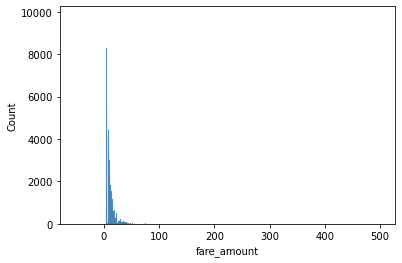

In [9]:
print("Max fare: {} || Min Fare: {}".format(max(uber_data.fare_amount), min(uber_data.fare_amount)))
print("Percentiles of fare: {}".format(np.percentile(uber_data.fare_amount, q = [2.5, 25, 50, 75, 97.5])))
sns.histplot(uber_data.fare_amount)

From looking at the min, max, and histogram together, we can see that there are outliers. We should drop all rows that have fare_amount under 0 because this is unrealistic. We should also drop values that are above the 97.5 percentile.

In [10]:
uber_data = uber_data[uber_data.fare_amount > 0]
uber_data = uber_data[uber_data.fare_amount <= np.percentile(uber_data.fare_amount, q = 97.5)]

# check percentiles to make sure correct drops were performed
print("Min Fare: {} || Max Fare: {}".format(min(uber_data.fare_amount), max(uber_data.fare_amount)))

Min Fare: 0.01 || Max Fare: 43.33


Now let's take another look at the histogram of fare_amount to get an idea of the distribution

<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

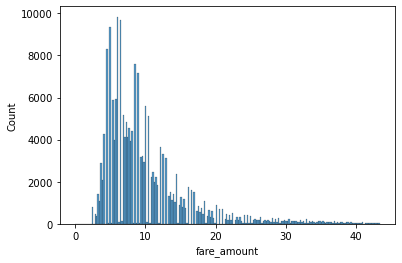

In [11]:
sns.histplot(uber_data.fare_amount)

Let's make sure latitude and longitude are possible

In [12]:
uber_data = uber_data[uber_data.pickup_latitude <= 90]
uber_data = uber_data[uber_data.pickup_latitude >= -90]
uber_data = uber_data[uber_data.pickup_longitude <= 180]
uber_data = uber_data[uber_data.pickup_longitude >= -180]
uber_data = uber_data[uber_data.dropoff_latitude <= 90]
uber_data = uber_data[uber_data.dropoff_latitude >= -90]
uber_data = uber_data[uber_data.dropoff_longitude <= 180]
uber_data = uber_data[uber_data.pickup_longitude >= -180]

### Create X (all features) and Y (fare_amount)

In [13]:
Y = uber_data.fare_amount
X = uber_data.drop(columns='fare_amount')
print("X shape: {} \nY shape: {}".format(X.shape, Y.shape))

X shape: (194975, 11) 
Y shape: (194975,)


### Split Data into Training sets and Testing sets

In [14]:
Xtr, Xte, Ytr, Yte = ms.train_test_split(X, Y) # shuffle is true by default & test_size is .25 by default
print("Xtr shape: {} \nXte shape: {} \nYtr shape: {}\nYte shape: {}".format(Xtr.shape, Xte.shape, Ytr.shape, Yte.shape))

Xtr shape: (146231, 11) 
Xte shape: (48744, 11) 
Ytr shape: (146231,)
Yte shape: (48744,)


## Search for the best preprocessing techniques

# This is going to be computationally *expensive*!!!

In [15]:
base_model = lm.Ridge(alpha = .01)

In [16]:
model_grid = {
    "Ridge Alpha = .1: ": lm.Ridge(alpha = .1), 
    "Ridge Alpha = .01: ": lm.Ridge(alpha = .01), 
    "Ridge Alpha = .001: ": lm.Ridge(alpha = .001), 
    "Ridge Alpha = .0001: ": lm.Ridge(alpha = .0001)
    }
scaler_grid = {
    'MinMax': pp.MinMaxScaler(), 
    'Robust': pp.RobustScaler(), 
    'Standard': pp.StandardScaler()
    }
transformer_grid = {
    'Quantile': pp.QuantileTransformer()
#, 'Power': pp.PowerTransformer()
    }

In [17]:
scores = {}
base_model.fit(Xtr, Ytr)
base_y_preds = base_model.predict(Xte)
error = mean_squared_error(base_y_preds, Yte)
print("No Transformations: {}".format(error))
scores["No Transformations"] = error
best_score = error
best_model_name = "base_model"
best_model = None
best_scaler_name = "None"
best_scaler = None
best_transformer_name = "None"
best_transformer = None

for h, (model_name, model) in enumerate(model_grid.items()):
    for i, (scaler_name, scaler) in enumerate(scaler_grid.items()):
        for j, (transformer_name, transformer) in enumerate(transformer_grid.items()):
            pipe = pipeline.make_pipeline(scaler, transformer, model)
            pipe.fit(Xtr, Ytr)
            y_preds = pipe.predict(Xte)
            score = mean_squared_error(y_preds, Yte)
            combination = scaler_name + ", " + transformer_name
            scores[combination] = score
            print("{} {}".format(combination, score))
            if score < best_score:
                best_score = score
                best_model_name = model_name
                best_model = model
                best_scaler_name = scaler_name
                best_scaler = scaler
                best_transformer_name = transformer_name
                best_transformer = transformer
                best_pipe = pipe

print("\nBest Combination:\nBest Scaler: {}\nBest Transformer: {}\nBest Score: {}".format(best_scaler_name, best_transformer_name, best_score))


No Transformations: 43.19362461251265
MinMax, Quantile 41.186701187062596
Robust, Quantile 41.19530573508277
Standard, Quantile 41.185193481540175
MinMax, Quantile 41.19756454432539
Robust, Quantile 41.19129904316612
Standard, Quantile 41.19108152316164
MinMax, Quantile 41.18468188662461
Robust, Quantile 41.1934545019372
Standard, Quantile 41.18725105107852
MinMax, Quantile 41.18744088046266
Robust, Quantile 41.184002414957384
Standard, Quantile 41.19369802649743

Best Combination:
Best Scaler: Robust
Best Transformer: Quantile
Best Score: 41.184002414957384


Lets see if polynomial features plays any part now...

In [18]:
cv_scores = ms.cross_validate(best_pipe, Xtr, Ytr, scoring = "neg_root_mean_squared_error")

In [19]:
cv_scores['test_score']

array([-6.44441228, -6.41961014, -6.52119579, -6.38850959, -6.44955665])

In [20]:
poly_feats_grid = {
    "pf = 1: ": pp.PolynomialFeatures(degree = 1), 
    "pf = 2:": pp.PolynomialFeatures(degree = 2),
    "pf = 3: ": pp.PolynomialFeatures(degree = 3),
    "pf = 4:": pp.PolynomialFeatures(degree = 4),
    }

In [21]:
scores = {}
base_model.fit(Xtr, Ytr)
base_y_preds = base_model.predict(Xte)
error = mean_squared_error(base_y_preds, Yte)
print("No Transformations: {}".format(error))
scores["No Transformations"] = error
best_score = error
best_model_name = "base_model"
best_model = None
best_scaler_name = "None"
best_scaler = None
best_transformer_name = "None"
best_transformer = None

for h, (model_name, model) in enumerate(model_grid.items()):
    for i, (scaler_name, scaler) in enumerate(scaler_grid.items()):
        for j, (transformer_name, transformer) in enumerate(transformer_grid.items()):
            for k, (pf_degree, poly_feats) in enumerate(poly_feats_grid.items()):
                pipe = pipeline.make_pipeline(scaler, transformer, poly_feats, model)
                #pipe.fit(Xtr, Xte)
                cv_scores = ms.cross_validate(pipe.fit(Xtr, Ytr), Xtr, Ytr, scoring='neg_mean_squared_error')
                #y_preds = pipe.predict(Xte)
                combination = model_name + ", " + scaler_name + ", " + transformer_name + ", " + pf_degree + ": "
                # score = mean_squared_error(y_preds, Yte)
                score = -1 * (sum(cv_scores['test_score']) / len(cv_scores['test_score']))
                scores[combination] = score
                print("{}: {}\n".format(combination, scores[combination]))
                if score < best_score:
                    best_score = score
                    best_model_name = model_name
                    best_model = model
                    best_scaler_name = scaler_name
                    best_scaler = scaler
                    best_transformer_name = transformer_name
                    best_transformer = transformer
                    best_pf_degree = pf_degree
                    best_pf = poly_feats
                    #best_y_preds = y_preds
                    best_pipe = pipe
                    best_cv_stats = cv_scores
                    print("\nNew Best: {}, {}, {}, {}\nScore: {}".format(model_name, scaler_name, transformer_name, pf_degree, score))

print("\nBest Combination:\nBest Alpha: {}\nBest Scaler: {}\nBest Transformer: {}\nBest PolyFeat Degree: {}\nBest Score: {}".format(best_model_name, best_scaler_name, best_transformer_name, best_pf_degree, best_score))


No Transformations: 43.19362461251265
Ridge Alpha = .1: , MinMax, Quantile, pf = 1: : : 41.53624917208364


New Best: Ridge Alpha = .1: , MinMax, Quantile, pf = 1: 
Score: 41.53624917208364
Ridge Alpha = .1: , MinMax, Quantile, pf = 2:: : 24.135884026331986


New Best: Ridge Alpha = .1: , MinMax, Quantile, pf = 2:
Score: 24.135884026331986
Ridge Alpha = .1: , MinMax, Quantile, pf = 3: : : 21.512549659262806


New Best: Ridge Alpha = .1: , MinMax, Quantile, pf = 3: 
Score: 21.512549659262806
Ridge Alpha = .1: , MinMax, Quantile, pf = 4:: : 16.132528195051783


New Best: Ridge Alpha = .1: , MinMax, Quantile, pf = 4:
Score: 16.132528195051783
Ridge Alpha = .1: , Robust, Quantile, pf = 1: : : 41.534860291465236

Ridge Alpha = .1: , Robust, Quantile, pf = 2:: : 24.144962926217026

Ridge Alpha = .1: , Robust, Quantile, pf = 3: : : 21.51377209886961

Ridge Alpha = .1: , Robust, Quantile, pf = 4:: : 16.13638401938948

Ridge Alpha = .1: , Standard, Quantile, pf = 1: : : 41.53631244175345

Ridge

In [22]:
best_pipe.named_steps

{'robustscaler': RobustScaler(),
 'quantiletransformer': QuantileTransformer(),
 'polynomialfeatures': PolynomialFeatures(degree=4),
 'ridge': Ridge(alpha=0.01)}

## Time to put our best model up against the Test Set

In [25]:
best_pipe.fit(Xtr, Ytr)
y_preds = best_pipe.predict(Xte)
rmse = mean_squared_error(Yte, y_preds)
print("Test Error: {}".format(rmse))

Test Error: 15.861391525869498


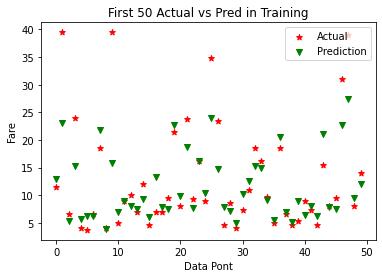

In [26]:
plt.title("First 50 Actual vs Pred in Training")
plt.ylabel("Fare")
plt.xlabel("Data Pont")
plt.scatter(np.arange(0, 50), Yte[:50], color='r', label = "Actual", marker = '*')
plt.scatter(np.arange(0, 50), y_preds[:50], color = 'g', label = "Prediction", marker = 'v')
plt.legend()